<a href="https://colab.research.google.com/github/RCortez25/Scientific-Machine-Learning/blob/main/Differential_equations/Pendulum_(MTK).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

# Code walkthrough

In [ ]:
# A
using ModelingToolkit, DifferentialEquations, Plots, LaTeXStrings

# B
@parameters t L m g
@variables  θ(t) ω(t) M(t)

# C
Dt = Differential(t)

*   **A**: Import the necessary libraries.
    * `ModelingToolkit` (MTK) helps one declare symbols and equations, then turns them into efficient code. Let's one build systems.
    * `DifferentialEquations` contains the solvers, e.g. `Tsit5`
    * `Plots` for plotting the results
*   **B**: Define the independent, dependent variables, constants, and the operators
    * `@parameters` for the independent variables (`t`) and the constants. This is part of the MTK library
    * `@variables` for the dependent variables
*   **C**: Definition of the differential operator $d/dt$

It is important to note that MTK's `@paremeter` contains "everything that is not a state variable", that's why `t` is included alongside with constants like `g, L, m`.

A **state variable** in this case is a quantity that determines the system's future through equations (alongside inputs and parameters). State variables are the ones to be integrated.

However, quantities that go inside `@variables` are not all states, but also inputs or observed variables that vary with time, like `M` in this case.

In this case, the **state** is given by $\{\theta, \omega\}$, of as a vector as

$$
\begin{pmatrix}
\theta \\ \omega
\end{pmatrix}
$$

In [ ]:
# A
eqs = [
    Dt(θ) ~ ω,
    M     ~ 0.1*sin(t),
    Dt(ω) ~ -(3g/(2L))*sin(θ) + (3/(m*L^2))*M
]

*   **A**: Definition of the governing equations of the system using Julia's notation. Here one defines the full set of relations of the system, not just the ones involving the state variables. In can include:

    *   Differential equations
    *   Albebraic/observed equations
    *   Definitions/constraints (e.g., geometry relations, conservation laws)


In this case one has

$$
\begin{align}
\dot{\theta} &= \omega(t) \\
\ddot{\theta} &= \dot{\omega} = -\frac{3g}{2l}\sin(\theta)+\frac{3}{ml^2}M(t) \\
M(t) &= 0.1\sin(t)
\end{align}
$$

That is, the velocity and the acceleration.

`~` in MTK means `=`. MTK sees `Dt(θ)` and tags `θ` as as state variable. The same applies for `ω`. It's important to note that MTK will tag a variable as a state variable if it is acted upon a differential operator, that's why `M` here is not treated as a state variable. In this case

$$M(t)=0.1\sin(t)$$

is just an algebraic equation.

If we change the variables later (like `M`, or `g,l,m`) we won't touch the equations directly, as they are symbolic in this array.

Note: In this case we define `M` because we can then modify later for another kind of input. One can thought it is redundant because we can write the definition in the equation for the acceleration but since we want to experiment with different inputs we define its own equation.

In [ ]:
# A
@named sys = ODESystem(eqs, t, [θ, ω, M], [L, m, g])

# B
simplified = structural_simplify(sys)

*   **A**: Create the ODEs system. The `ODESystem` constructor needs:
    * The equations of the system
    * The independent variables (only `t` in this case).
    * The dependent variables (all time-varying variables, not just differential states).
    * The constants

    The `@named` gives a name to the system. If in other cases there are various systems, this helps keep track of them. Also helps in conncecting different systems, and the name appears in graphs and summaries which also helps with debugging.

*   **B**: This is like a "dependable algebra assistant". Here MTK
    * Classifies variables as state variables, algebraic, etc
    * Substitutes definitions, like `M` in this case. This eliminates redundant algebraic relations in case they're present.
    * Reduces Differential Algebraic Equations (index reduction) to ODEs when constraints are present.
    * Builds a consistent evaluation order, avoiding implicit loops and ensuring everything can be computed from upstream quantities.
    * Simplification yields cleaner and faster RHS/Jacobian for the numeric solver.

In this case, since it is a small system we can do everything by hand, but as the systems get complicated and scale (add constraints, components, piecewise inputs, etc) using `structural_simplify` is the way to go as it handles everything under the hood for us.

Getting in the habit of using it guarantees correct classification/substitution and keeps things robust as the model grows.

`structural_simplify` prepares the scene for the solver to come into the picture.

In [ ]:
# A
parameter_map      = Dict(L => 1.0, m => 1.0, g => 9.81)

# B
initial_conditions = Dict(θ => 0.01, ω => 0.0)

# C
timespan           = (0.0, 10.0)



*   **A**: Create a dictionary to give values to the constants of the problem. The keys are not strings but the symbols defined in `@parameters`. This helps us change the values later in this dictionary directly if one wants without touching the equations defined above.
*   **B**: Same as **A** for for the initial conditions. These are only for state variables. MTK maps each state variable to its initial condition nicely in this dictionary, which we can change later here without modifying the equations directly.
*   **C**: The time window of the simulation $(t_0,t)$



In [ ]:
# A
problem = ODEProblem(simplified, merge(initial_conditions, parameter_map), timespan)



*   **A**: Once the system is simplified, the `ODEProblem` constructor gathers everything that is needed in order to create an ODE problem that solvers understand. It takes
    * The simplified system
    * The initial conditions
    * The specific parameters
    * The time window of the simulation

The `merge` function merges the two dictionaries, but it's only a Julia convention. If one forgets an IC for a state one gets an `value not found` error. If one puts `M` into the initial contidions, it's ignored as it isn't a state variable.


In [ ]:
# A
sol = solve(problem, Tsit5(), saveat=0.01)



*   **A**: Runs the numeric integrator on the ODEProblem defined above. In this particular case, we have
    * `Tsit5()` a standard non-stiff 5th-order method
    * `saveat=0.01` for recording the solution at every 0.01 time steps. This gives evenly spaced samples in `sol.t`, and creates a smoother plot.

We can read the solution object as

*   `sol.t`: The time steps
*   `sol[θ]`: Vector of $\theta(t)$ at the time steps
*   `sol[ω]`: Vector of $\omega(t)$ at the time steps

And we can evaluate (interpolate) the solution at any position in time as `sol(t)` in the interval `[0,10]`.


In [ ]:
# A
p1 = plot(sol.t, sol[θ],
    label = "θ(t)",
    xlabel = "t (s)",
    ylabel = "θ (rad)",
    title  = "Displacement",
    lw = 2,
)

p2 = plot(sol.t, sol[ω],
    label = "ω(t)",
    xlabel = "t (s)",
    ylabel = "ω (rad/s)",
    title  = "Angular velocity",
    lw = 2,
)

# B
plot(p1, p2, layout = (2,1), link = :x)

# C
savefig("Pendulum.png")



*   **A**: Plotting the solution of the integrated state variables. `sol.t` queries the solution for the time values and plots them in the $x$-axis, whereas `sol[θ]` obtains the solution vector for `θ` at those points in time, plotting them in the $y$-axis. `lw` stands for _line width_.
*   **B**: The two plots are arranged in a `layout=(2,1)` panel of 2 rows and 1 column. `link = :x` means to synchronize boths plots's $x$-axis, if one zooms in one plot, the other updates to match.
*   **C**: Save the figure as _Pendulum.png_ in the working directory.



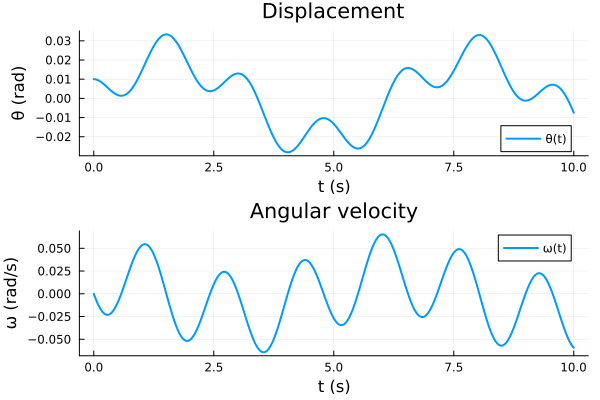